In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
Base.classes.keys()

['measurement', 'station']

In [8]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
#Start Date for Trip - 2018-03-01
#End Date for Trip - 2018-03-07
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#Query for grabbing all dates, and then grabbing latest date in the Measurement table. 
all_dates = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).all()
all_dates_list = list(np.ravel(all_dates))
max_date = all_dates_list[0]
#Some code to make the dt.timedelta a bit easier. Have to be careful - format needs to be 'YYYY-MM-DD' for this to work.
max_date_year = int(max_date[0:4])
max_date_month = int(max_date[5:7])
max_date_day = int(max_date[8:10])

year_ago_from_max = dt.date(max_date_year, max_date_month, max_date_day) - dt.timedelta(days=366)
# Query to grab the prcp and the date for all dates up to a year ago from the latest date in the table.  
year_ago_from_max_data = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date > year_ago_from_max).all()\

# Code for flask app...comment out for Jupyter Notebook.  
# FYI this FLASK code managed to get my data into a dictionary which made it easy to JSONIFY
#all_list = list(np.ravel(year_ago_from_max_data))
#all_list
#res_dct = {all_list[i+1]: all_list[i] for i in range(0, len(all_list), 2)}          
#res_dct

In [13]:
#Creating a pandas dataframe to then make a bar chart from. 
year_ago_from_max_data = pd.DataFrame(year_ago_from_max_data)
year_ago_from_max_data = year_ago_from_max_data.dropna()
year_ago_from_max_data = year_ago_from_max_data.sort_values("date")


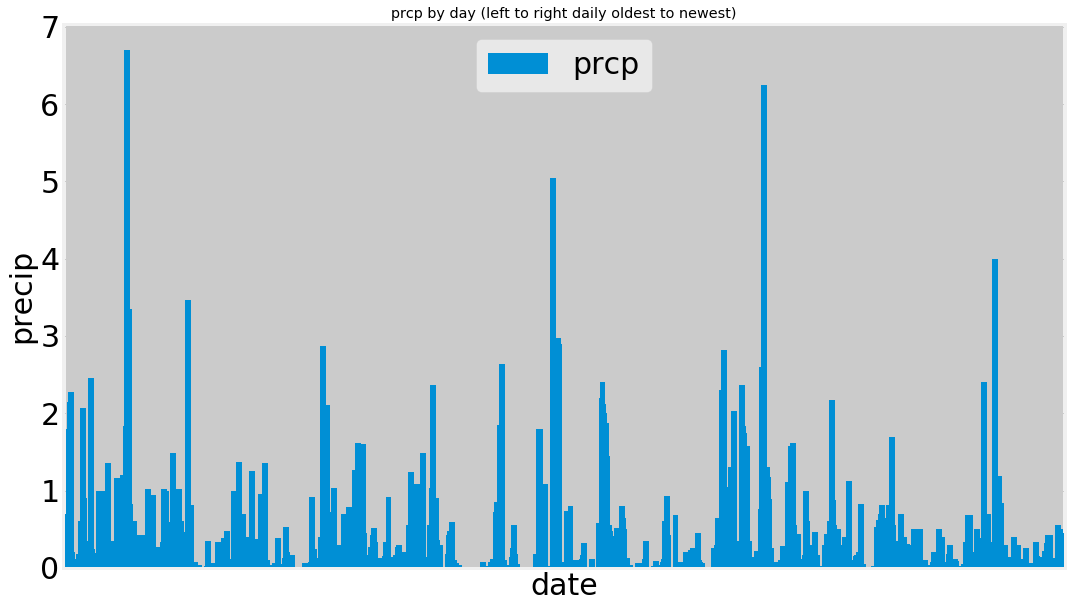

In [14]:
#df.plot a bar chart and use plt to add labels, font-size, etc. 
year_ago_from_max_data.plot(kind="bar", width=12, figsize=(16,10))
plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)
plt.yticks(fontsize=30)
plt.legend(loc="upper center", fontsize=30)
plt.xlabel("date", fontsize=30)
plt.ylabel("precip", fontsize=30)
plt.title("prcp by day (left to right daily oldest to newest)")
plt.show()



![precipitation](Images/precipitation.png)

In [15]:
#A quick .describe() to get the summary stats. 
year_ago_from_max_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
# Counting how many stations are in the dataset, then listing them below. 
number_stations = session.query(Station.name).count()
print(f'There are {number_stations} total stations... They are listed below')

stations = session.query(Station.name).all()
for station in stations:
    print(station)

There are 9 total stations... They are listed below
('WAIKIKI 717.2, HI US',)
('KANEOHE 838.1, HI US',)
('KUALOA RANCH HEADQUARTERS 886.9, HI US',)
('PEARL CITY, HI US',)
('UPPER WAHIAWA 874.3, HI US',)
('WAIMANALO EXPERIMENTAL FARM, HI US',)
('WAIHEE 837.5, HI US',)
('HONOLULU OBSERVATORY 702.2, HI US',)
('MANOA LYON ARBO 785.2, HI US',)


In [17]:
#Querying for all the stations and their measurements, converting to pandas df, grouping by station and using .count and .sort_values to get a nice looking summary
active_stations = session.query(Measurement.station, Measurement.tobs).all()
active_stations = pd.DataFrame(active_stations)
active_stations = active_stations.groupby("station").count().sort_values("tobs", ascending=False)
active_stations = active_stations.rename(columns={"tobs":"count of measurments"})
active_stations

,count of measurments
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [18]:
#Query for data at the most active station, then get MIN, MAX, and AVG temps out of all the measurements. 
low_temp_at_active_station = session.query(Measurement.station, Measurement.tobs).\
    filter_by(station="USC00519281").all()
low_temp_at_active_station = pd.DataFrame(low_temp_at_active_station)
mintobs = low_temp_at_active_station["tobs"].min()
maxtobs = low_temp_at_active_station["tobs"].max()
avgtobs = low_temp_at_active_station["tobs"].mean()

print(f'The lowest temp at the most active station (USC00519281) is {mintobs}')
print(f'The highest temp at the most active station (USC00519281) is {maxtobs}')
print(f'The average temp at the most active station (USC00519281) is {avgtobs}')

The lowest temp at the most active station (USC00519281) is 54.0
The highest temp at the most active station (USC00519281) is 85.0
The average temp at the most active station (USC00519281) is 71.66378066378067


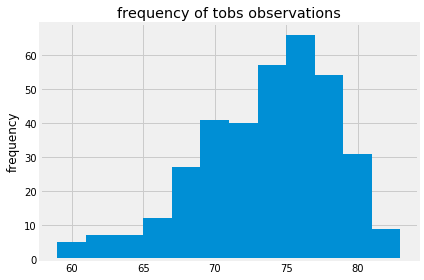

In [19]:
#Query for all the dates with measurements at the most active station to find the max date. 
all_dates = session.query(Measurement.date, Measurement.station).\
    filter_by(station="USC00519281").\
    order_by(Measurement.date.desc()).all()
all_dates_list = list(np.ravel(all_dates))
max_date = all_dates_list[0]

#Because the date is formatted "YYYY-MM-DD" I can do this code to make timedelta easy to work with. 
max_date_year = int(max_date[0:4])
max_date_month = int(max_date[5:7])
max_date_day = int(max_date[8:10])

year_ago_from_max = dt.date(max_date_year, max_date_month, max_date_day) - dt.timedelta(days=365)

#This grabs all my measurements on the most active station, and only the dates from a year ago from max date. 
year_ago_from_max_data = session.query(Measurement.tobs).\
    filter(Measurement.station=="USC00519281").\
    filter(Measurement.date > year_ago_from_max).all()

#Plotting the results in the histogram with 12 bins
year_ago_from_max_data = pd.DataFrame(year_ago_from_max_data)
year_ago_from_max_data.hist(bins=12)
plt.ylabel("frequency")
plt.title("frequency of tobs observations")
plt.tight_layout()
plt.show()



![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-03-01', '2017-03-07')

idk = list(np.ravel(trip_temps))
TMIN = idk[0]
TAVE = idk[1]
TMAX = idk[2]

trip_temps

[(62.0, 71.02380952380952, 78.0)]

Text(14.435000000000002, 0.5, 'Degrees')

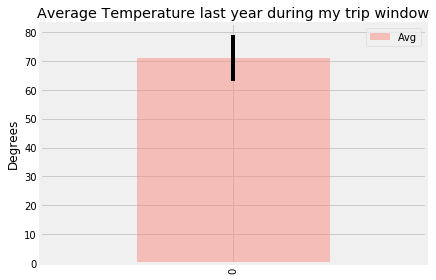

In [22]:
yerr = (TMAX-TMIN)/2

df = pd.DataFrame([{'Avg': TAVE}])

df.plot(kind="bar", yerr=yerr, color="salmon", alpha=.45)
plt.title("Average Temperature last year during my trip window")
plt.tight_layout()
plt.ylabel("Degrees")

In [23]:
#Query to get precip data between the same trip window last year. 
start_date = '2017-03-01'
end_date = '2017-03-07'

prcp_by_station = session.query(Measurement.station, Measurement.prcp).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

#Plop it into a df and group by station and use .sum() to get total precip values by station. 
prcp_by_station = pd.DataFrame(prcp_by_station)
prcp_by_station = prcp_by_station.groupby("station").sum().sort_values("prcp", ascending=False)
prcp_by_station = prcp_by_station.rename(columns={"prcp":"total prcp between start and end date"})
prcp_by_station

#Query to get station name, number, lat/long, elevation, and plop it into df - should check it out to test it, 
#should be able to merge right into the other df to make a nice viewable table
station_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_info = pd.DataFrame(station_info)
#station_info    #Just check out the df make sure it is mergable with previous. 

merge = pd.merge(prcp_by_station, station_info, on="station", how="outer")
merge


,station,total prcp between start and end date,name,latitude,longitude,elevation
0,USC00513117,4.80,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
1,USC00519281,4.71,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00516128,3.49,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
3,USC00517948,2.98,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00519397,2.74,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00519523,2.32,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00514830,1.12,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,USC00518838,NaN,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,USC00511918,NaN,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
#Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

def monthly_normals(date):
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m", Measurement.date) == date).all()

June_monthly = monthly_normals('06')
Dec_monthly = monthly_normals('12')
June_monthly = list(np.ravel(June_monthly))
Dec_monthly = list(np.ravel(Dec_monthly))

print(f'Of all the data, the min temp in June is {June_monthly[0]} degrees')
print(f'The avg temp in June is {June_monthly[1]} degrees')
print(f'The maximum temp in June is {June_monthly[2]} degrees')
print(f'----------------------------------------------------------')
print(f'Of all the data, the min temp in December is {Dec_monthly[0]} degrees')
print(f'The avg temp in December is {Dec_monthly[1]} degrees')
print(f'The maximum temp in December is {Dec_monthly[2]} degrees')

Of all the data, the min temp in June is 64.0 degrees
The avg temp in June is 74.94411764705882 degrees
The maximum temp in June is 85.0 degrees
----------------------------------------------------------
Of all the data, the min temp in December is 56.0 degrees
The avg temp in December is 71.04152933421226 degrees
The maximum temp in December is 83.0 degrees


In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates


# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [28]:
# Plot the daily normals as an area plot with `stacked=False`
